In [48]:
import tensorflow as tf

import numpy as np
import scipy.sparse as scs
from scipy.stats import multinomial
import pathlib as pl
import pandas as pd
import matplotlib.pyplot as plt


import umap as um
#from sklearn.linear_model import Lasso
#import itertools 

from os import listdir
from os.path import isfile, join

import random


from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import os
import pickle

from plot_results import get_dbl_metrics

In [49]:
path = '../data/npy_objs/'
files = [f for f in listdir(path) if (isfile(join(path, f)) & (f[-11:] == '_counts.npy'))]
files = files[:-1]
files

['HEK-HMEC-MULTI_counts.npy',
 'pbmc-1A-dm_counts.npy',
 'cline-ch_counts.npy',
 'hm-12k_counts.npy',
 'hm-6k_counts.npy',
 'HMEC-orig-MULTI_counts.npy',
 'HMEC-rep-MULTI_counts.npy',
 'J293t-dm_counts.npy',
 'mkidney-ch_counts.npy',
 'nuc-MULTI_counts.npy',
 'pbmc-1B-dm_counts.npy',
 'pbmc-1C-dm_counts.npy',
 'pbmc-2ctrl-dm_counts.npy',
 'pbmc-2stim-dm_counts.npy',
 'pbmc-ch_counts.npy',
 'pdx-MULTI_counts.npy']

In [50]:
#files = files[-2:]
files

['HEK-HMEC-MULTI_counts.npy',
 'pbmc-1A-dm_counts.npy',
 'cline-ch_counts.npy',
 'hm-12k_counts.npy',
 'hm-6k_counts.npy',
 'HMEC-orig-MULTI_counts.npy',
 'HMEC-rep-MULTI_counts.npy',
 'J293t-dm_counts.npy',
 'mkidney-ch_counts.npy',
 'nuc-MULTI_counts.npy',
 'pbmc-1B-dm_counts.npy',
 'pbmc-1C-dm_counts.npy',
 'pbmc-2ctrl-dm_counts.npy',
 'pbmc-2stim-dm_counts.npy',
 'pbmc-ch_counts.npy',
 'pdx-MULTI_counts.npy']

In [51]:
seeds = [42, 29503, 432809, 42, 132975, 9231996, 12883823, 9231996, 1234, 62938, 57203 ,109573, 23]

In [59]:
#HYPERPARAMS
neighbors = 100
eps  = 1000#40#100
enc_sze = 5#8#7
use_old=False
save=True

In [62]:
#- vae
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

def plt_loss(hist):
    x = np.arange(len(hist.history['loss']))
    keysv = list(hist.history.keys())
    
    for k in keysv[:-1]:
        plt.plot(x, np.array(hist.history[k]), label = k)
    plt.title('loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')    
    


def define_vae(enc_sze, ngens):
    
    tfk  = tf.keras
    tfkl = tf.keras.layers
    tfpl = tfp.layers
    tfd  = tfp.distributions

    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_sze), scale=1),
            reinterpreted_batch_ndims=1)
    
    encoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[ngens]),
        tfkl.Dense(256, activation='relu'),#, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seeds[0])),
        tfkl.BatchNormalization(),
        tfkl.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(enc_sze), activation=None),#, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seeds[1])),
        tfpl.IndependentNormal(
            enc_sze,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior)
        )
    ], name='encoder')

    decoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[enc_sze]),
        tfkl.Dense(256, activation='relu'),#, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seeds[2])),
        tfkl.BatchNormalization(),
        tfkl.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(ngens), activation=None),#, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seeds[3])),
        tfpl.IndependentNormal(ngens)
    ], name='decoder')


    IPT     = tfk.Input(shape = ngens)
    z       = encoder(IPT)
    OPT1    = decoder(z)

    vae = tfk.Model(inputs=[IPT],
                      outputs=[OPT1])
    
    def nll(x, rv_x): 
        rec = rv_x.log_prob(x)
        return -tf.math.reduce_sum(rec, axis=-1) 
    
    vae.compile(optimizer = tf.optimizers.Adamax(learning_rate=1e-3),#Adam
                  loss=nll)
    #1e-3
    return vae




In [63]:
from sklearn.model_selection import train_test_split


In [64]:
#vae_embeddings - LR = 1e-3
#vae_embeddings2 - LR = 1e-3, adamax, patience 20, best F
#vae_embeddings3 - LR = 1e-4, adamax, patience 20, best F
data_dir = 'sce_normalized_data'

#vae_embeddings_scheduled
#vae_embeddings_scheduled_adamax

#vae_embedding_log_doubs - LR = 1e-3
#data_dir = 'sce_normalized_data_log_doubs'

#files = ['J293t-dm_counts.npy', 'HEK-HMEC-MULTI_counts.npy',  'pbmc-1A-dm_counts.npy',  'hm-12k_counts.npy', 'mkidney-ch_counts.npy', 'nuc-MULTI_counts.npy']

HEK-HMEC-MULTI


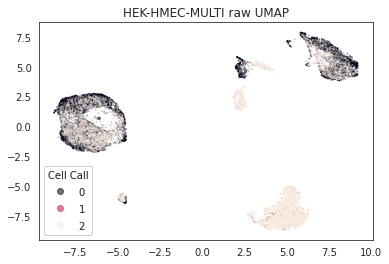

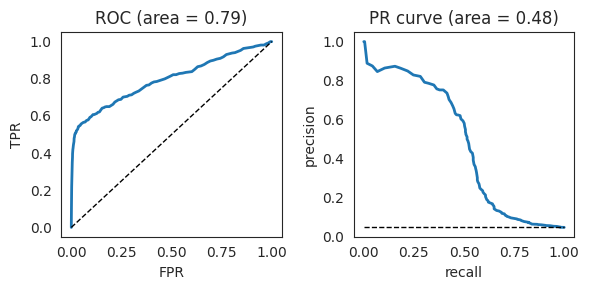

generating new VAE encoding
Epoch 1/1000
315/315 [==============================] - 3s 6ms/step - loss: 97390.6774 - val_loss: 77888.4531
Epoch 2/1000
315/315 [==============================] - 1s 5ms/step - loss: 82291.9497 - val_loss: 74892.1562
Epoch 3/1000
315/315 [==============================] - 2s 5ms/step - loss: 78597.8486 - val_loss: 73096.5859
Epoch 4/1000
315/315 [==============================] - 1s 5ms/step - loss: 76309.2440 - val_loss: 72207.4844
Epoch 5/1000
315/315 [==============================] - 2s 5ms/step - loss: 74921.8717 - val_loss: 71831.0156
Epoch 6/1000
315/315 [==============================] - 1s 5ms/step - loss: 74171.0350 - val_loss: 71370.7656
Epoch 7/1000
315/315 [==============================] - 1s 5ms/step - loss: 73442.0775 - val_loss: 71159.7578
Epoch 8/1000
315/315 [==============================] - 1s 5ms/step - loss: 72864.4055 - val_loss: 70930.0938
Epoch 9/1000
315/315 [==============================] - 1s 4ms/step - loss: 72527.5095 - val

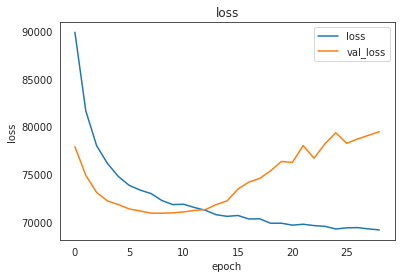

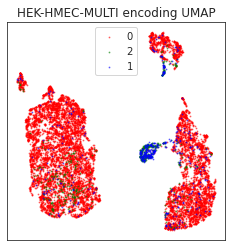

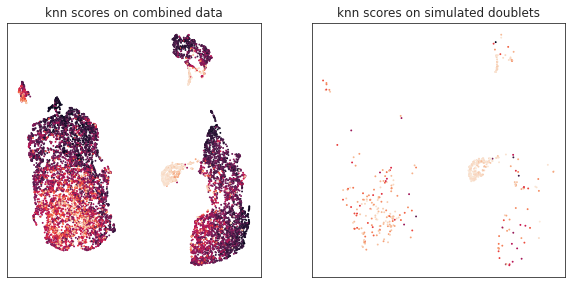

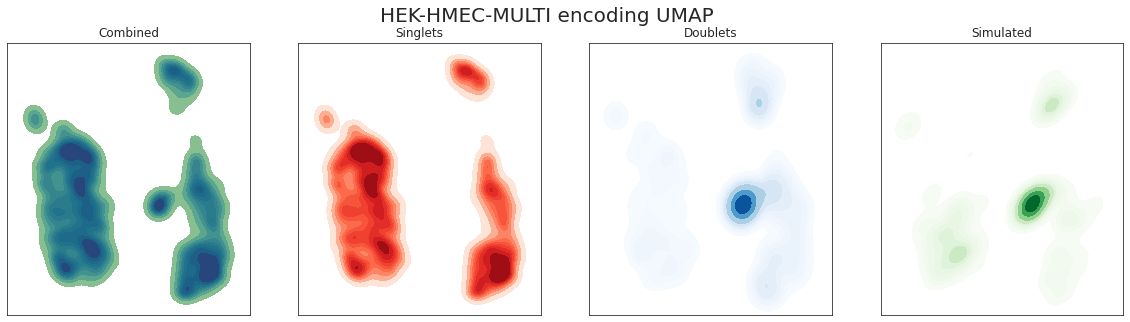

pbmc-1A-dm


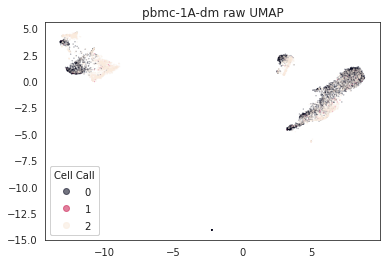

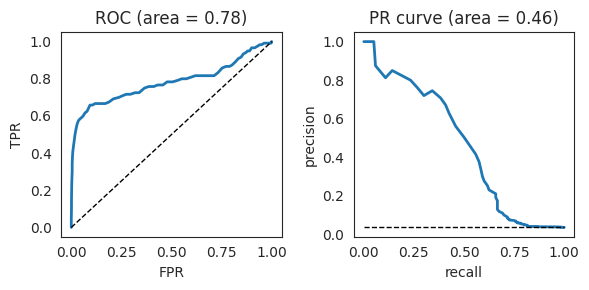

generating new VAE encoding
Epoch 1/1000
100/100 [==============================] - 2s 8ms/step - loss: 127639.3240 - val_loss: 103902.1562
Epoch 2/1000
100/100 [==============================] - 1s 5ms/step - loss: 110426.7439 - val_loss: 100454.1016
Epoch 3/1000
100/100 [==============================] - 1s 5ms/step - loss: 105057.2099 - val_loss: 98292.2109
Epoch 4/1000
100/100 [==============================] - 1s 5ms/step - loss: 103594.8646 - val_loss: 97405.6875
Epoch 5/1000
100/100 [==============================] - 0s 5ms/step - loss: 100628.3152 - val_loss: 96040.7891
Epoch 6/1000
100/100 [==============================] - 1s 5ms/step - loss: 97672.6568 - val_loss: 95503.8750
Epoch 7/1000
100/100 [==============================] - 0s 5ms/step - loss: 97441.4811 - val_loss: 94666.2188
Epoch 8/1000
100/100 [==============================] - 0s 5ms/step - loss: 95478.5690 - val_loss: 94157.9297
Epoch 9/1000
100/100 [==============================] - 0s 5ms/step - loss: 94437.245

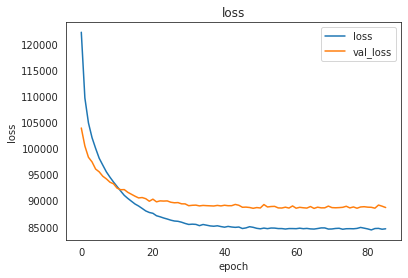

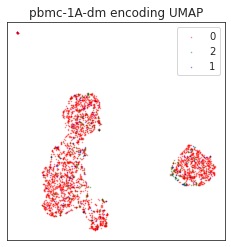

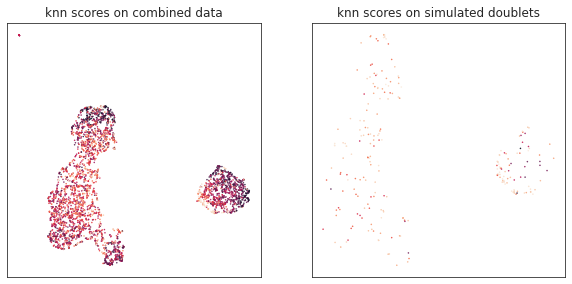

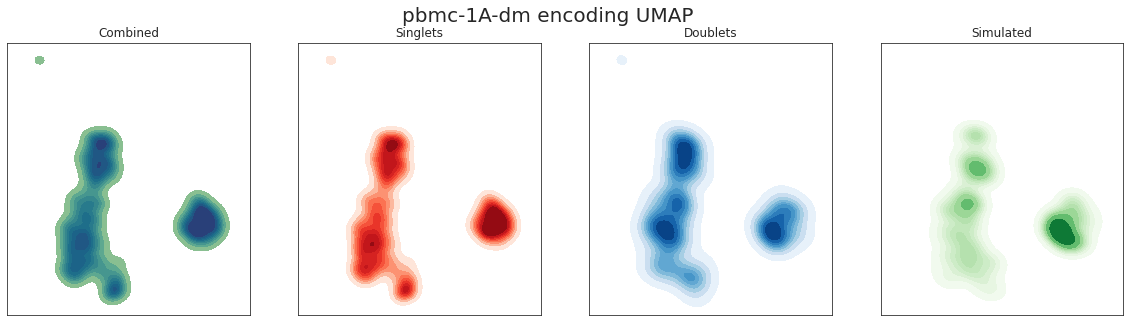

cline-ch


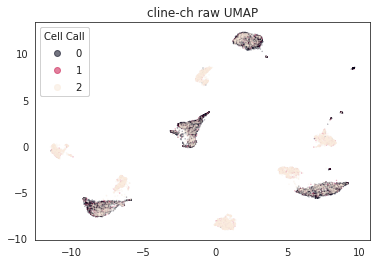

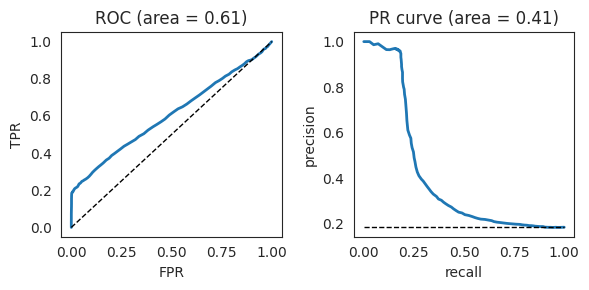

generating new VAE encoding
Epoch 1/1000
235/235 [==============================] - 3s 6ms/step - loss: 112483.8736 - val_loss: 77992.2266
Epoch 2/1000
235/235 [==============================] - 1s 5ms/step - loss: 84166.8787 - val_loss: 72518.9609
Epoch 3/1000
235/235 [==============================] - 1s 5ms/step - loss: 78621.9316 - val_loss: 70187.2891
Epoch 4/1000
235/235 [==============================] - 1s 5ms/step - loss: 76188.6170 - val_loss: 68471.9219
Epoch 5/1000
235/235 [==============================] - 1s 5ms/step - loss: 72952.1912 - val_loss: 67328.5625
Epoch 6/1000
235/235 [==============================] - 1s 5ms/step - loss: 71492.7510 - val_loss: 66629.9531
Epoch 7/1000
235/235 [==============================] - 1s 5ms/step - loss: 69985.8080 - val_loss: 65787.2266
Epoch 8/1000
235/235 [==============================] - 1s 5ms/step - loss: 68639.4460 - val_loss: 65245.9531
Epoch 9/1000
235/235 [==============================] - 1s 5ms/step - loss: 67362.0638 - va

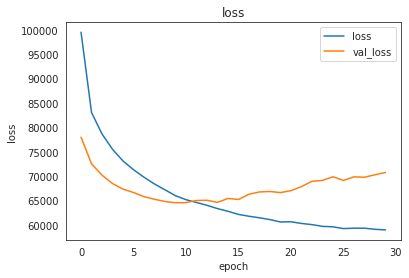

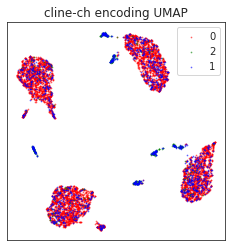

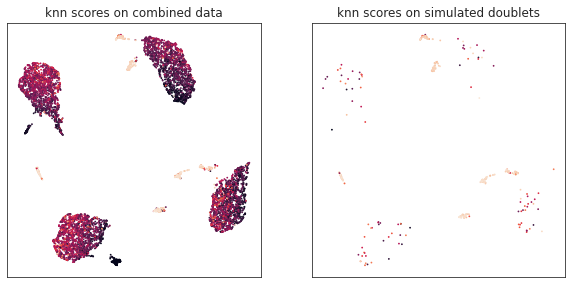

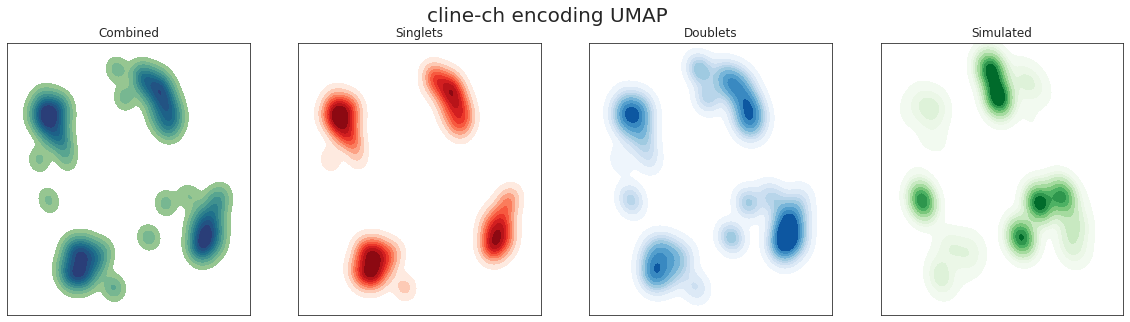

hm-12k


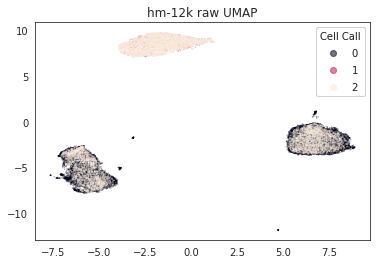

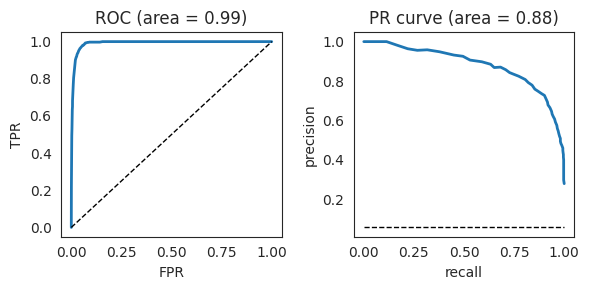

generating new VAE encoding
Epoch 1/1000
385/385 [==============================] - 3s 6ms/step - loss: 92761.6373 - val_loss: 71004.5547
Epoch 2/1000
385/385 [==============================] - 2s 5ms/step - loss: 75665.8985 - val_loss: 67976.5781
Epoch 3/1000
385/385 [==============================] - 2s 5ms/step - loss: 72254.5863 - val_loss: 65716.8203
Epoch 4/1000
385/385 [==============================] - 2s 5ms/step - loss: 69627.8345 - val_loss: 64496.2852
Epoch 5/1000
385/385 [==============================] - 2s 4ms/step - loss: 67221.1093 - val_loss: 63616.5508
Epoch 6/1000
385/385 [==============================] - 2s 4ms/step - loss: 65630.1747 - val_loss: 62296.5898
Epoch 7/1000
385/385 [==============================] - 2s 5ms/step - loss: 63442.6081 - val_loss: 61987.1602
Epoch 8/1000
385/385 [==============================] - 2s 5ms/step - loss: 63705.0560 - val_loss: 61636.7109
Epoch 9/1000
385/385 [==============================] - 2s 5ms/step - loss: 62352.0200 - val

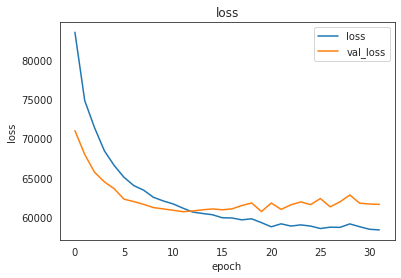

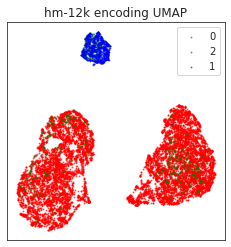

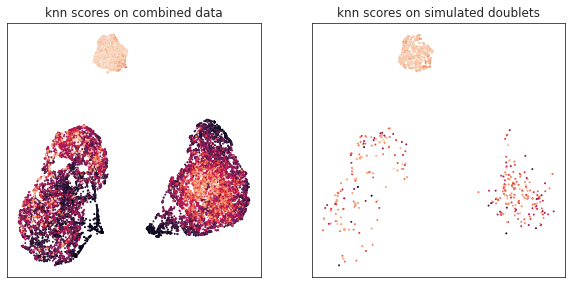

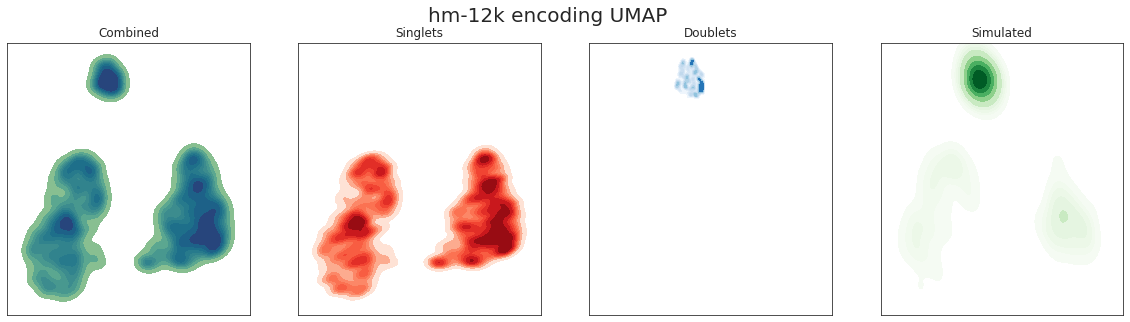

hm-6k


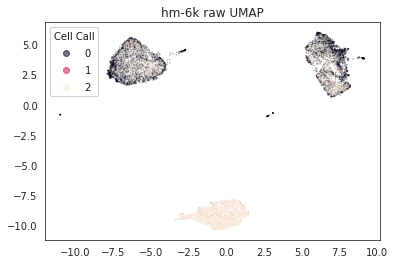

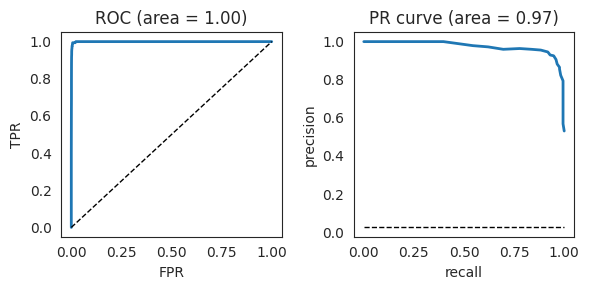

generating new VAE encoding
Epoch 1/1000
201/201 [==============================] - 2s 6ms/step - loss: 93835.7104 - val_loss: 71648.3516
Epoch 2/1000
201/201 [==============================] - 1s 5ms/step - loss: 78319.6222 - val_loss: 68424.2500
Epoch 3/1000
201/201 [==============================] - 1s 5ms/step - loss: 73211.7806 - val_loss: 66668.4844
Epoch 4/1000
201/201 [==============================] - 1s 5ms/step - loss: 71664.7423 - val_loss: 65124.7656
Epoch 5/1000
201/201 [==============================] - 1s 5ms/step - loss: 70559.6559 - val_loss: 64290.6523
Epoch 6/1000
201/201 [==============================] - 1s 5ms/step - loss: 69028.9632 - val_loss: 63719.8359
Epoch 7/1000
201/201 [==============================] - 1s 5ms/step - loss: 66543.5075 - val_loss: 62811.3945
Epoch 8/1000
201/201 [==============================] - 1s 5ms/step - loss: 65863.5053 - val_loss: 61756.6602
Epoch 9/1000
201/201 [==============================] - 1s 5ms/step - loss: 64687.2862 - val

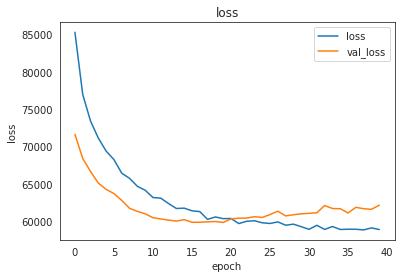

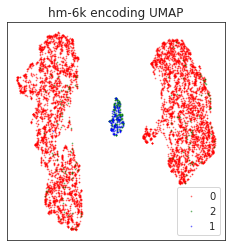

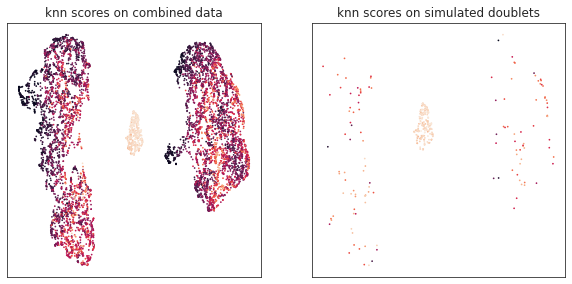

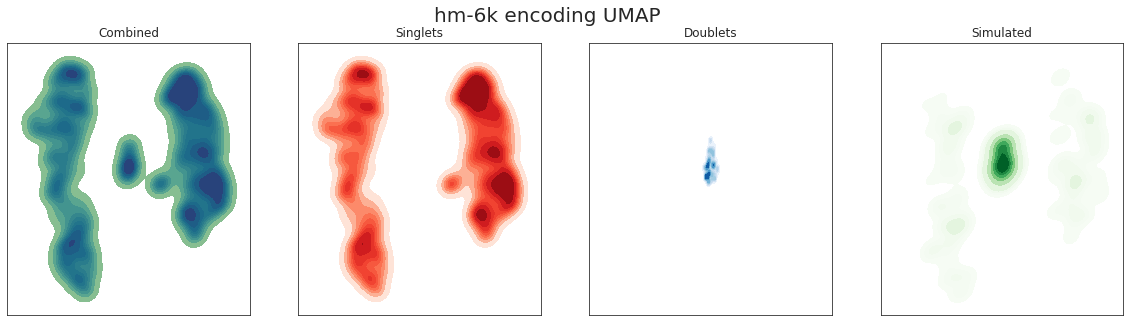

HMEC-orig-MULTI


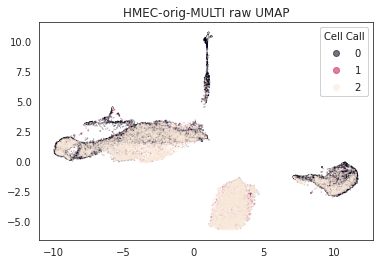

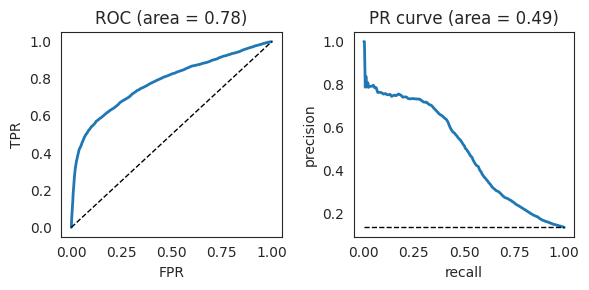

generating new VAE encoding
Epoch 1/1000
803/803 [==============================] - 5s 5ms/step - loss: 110285.4636 - val_loss: 89509.0234
Epoch 2/1000
803/803 [==============================] - 4s 5ms/step - loss: 92651.0161 - val_loss: 85419.9844
Epoch 3/1000
803/803 [==============================] - 4s 4ms/step - loss: 87299.9928 - val_loss: 83364.5312
Epoch 4/1000
803/803 [==============================] - 4s 4ms/step - loss: 84885.5357 - val_loss: 82637.7031
Epoch 5/1000
803/803 [==============================] - 4s 5ms/step - loss: 83619.8495 - val_loss: 82449.1250
Epoch 6/1000
803/803 [==============================] - 4s 5ms/step - loss: 82860.6178 - val_loss: 82508.2656
Epoch 7/1000
803/803 [==============================] - 4s 5ms/step - loss: 82300.3172 - val_loss: 82518.9531
Epoch 8/1000
803/803 [==============================] - 4s 5ms/step - loss: 81884.6330 - val_loss: 82785.8828
Epoch 9/1000
803/803 [==============================] - 4s 5ms/step - loss: 81298.6533 - va

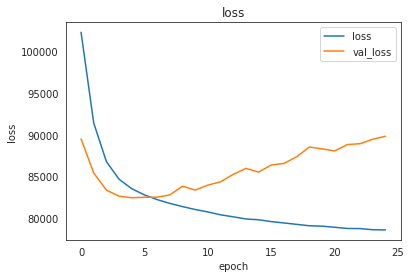

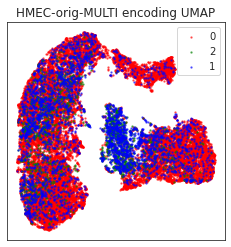

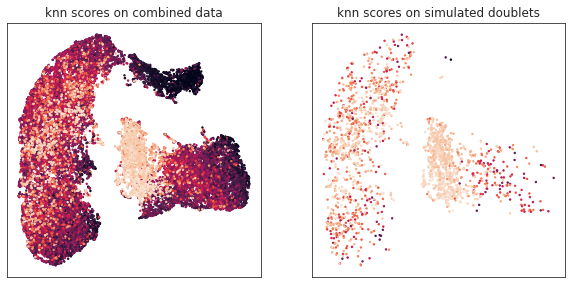

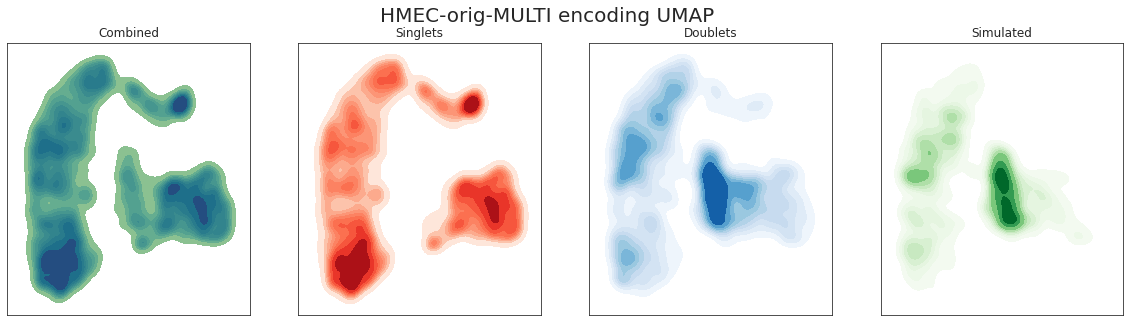

HMEC-rep-MULTI


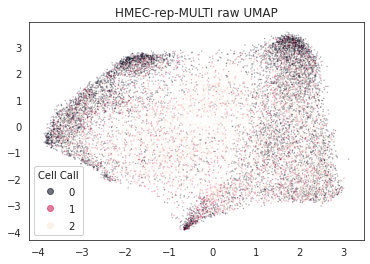

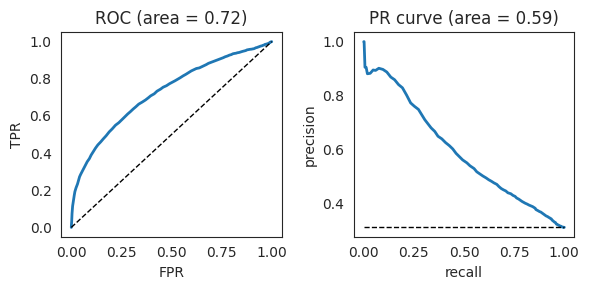

generating new VAE encoding
Epoch 1/1000
332/332 [==============================] - 3s 6ms/step - loss: 130684.1924 - val_loss: 102492.8906
Epoch 2/1000
332/332 [==============================] - 2s 5ms/step - loss: 107954.7760 - val_loss: 97990.5938
Epoch 3/1000
332/332 [==============================] - 2s 5ms/step - loss: 101379.4217 - val_loss: 94040.1562
Epoch 4/1000
332/332 [==============================] - 2s 5ms/step - loss: 96351.9996 - val_loss: 91155.2188
Epoch 5/1000
332/332 [==============================] - 2s 5ms/step - loss: 92904.9025 - val_loss: 89213.4531
Epoch 6/1000
332/332 [==============================] - 2s 5ms/step - loss: 91537.4479 - val_loss: 87859.4922
Epoch 7/1000
332/332 [==============================] - 2s 5ms/step - loss: 89021.7290 - val_loss: 87057.1875
Epoch 8/1000
332/332 [==============================] - 2s 5ms/step - loss: 87926.7788 - val_loss: 86603.6250
Epoch 9/1000
332/332 [==============================] - 2s 5ms/step - loss: 87062.5011 -

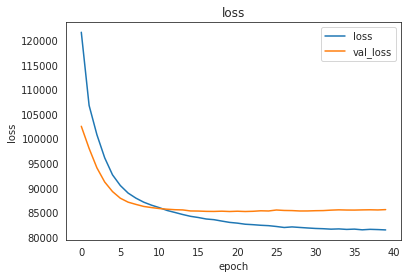

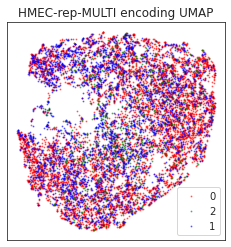

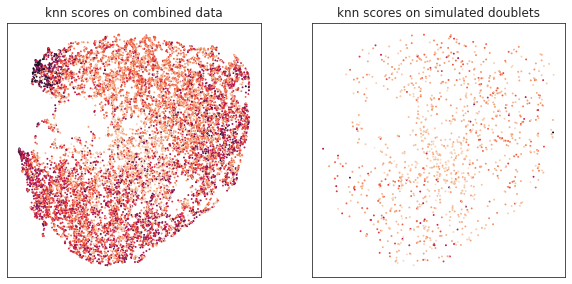

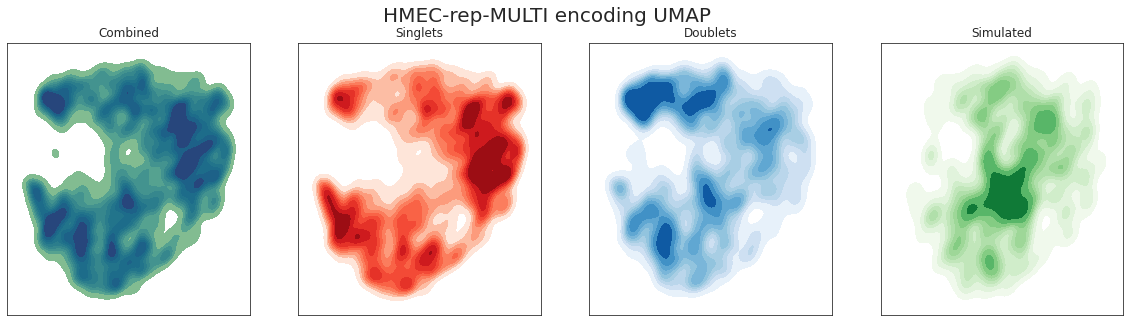

J293t-dm


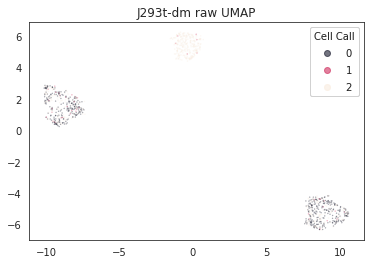

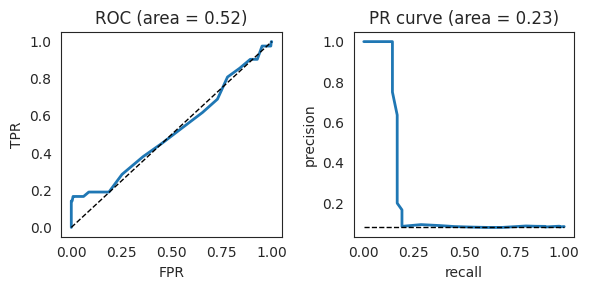

generating new VAE encoding
Epoch 1/1000
16/16 [==============================] - 3s 66ms/step - loss: 132764.1714 - val_loss: 94353.2656
Epoch 2/1000
16/16 [==============================] - 0s 9ms/step - loss: 109848.2785 - val_loss: 92135.8438
Epoch 3/1000
16/16 [==============================] - 0s 8ms/step - loss: 103516.2045 - val_loss: 90858.4609
Epoch 4/1000
16/16 [==============================] - 0s 7ms/step - loss: 100558.3502 - val_loss: 89334.5234
Epoch 5/1000
16/16 [==============================] - 0s 7ms/step - loss: 97315.2330 - val_loss: 88430.9531
Epoch 6/1000
16/16 [==============================] - 0s 7ms/step - loss: 97890.0680 - val_loss: 87381.5938
Epoch 7/1000
16/16 [==============================] - 0s 7ms/step - loss: 97676.3428 - val_loss: 86450.6172
Epoch 8/1000
16/16 [==============================] - 0s 7ms/step - loss: 95464.7661 - val_loss: 85736.2891
Epoch 9/1000
16/16 [==============================] - 0s 7ms/step - loss: 95144.6002 - val_loss: 85209.

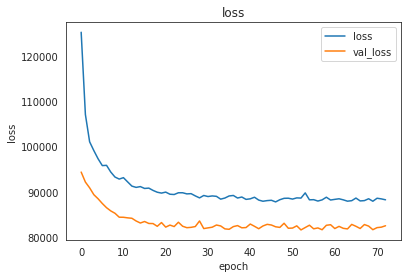

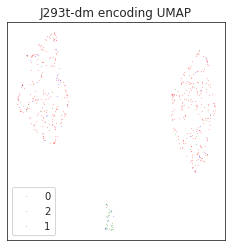

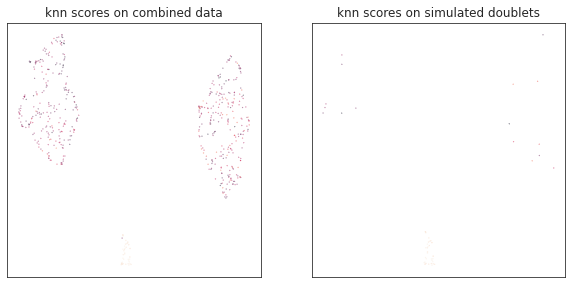

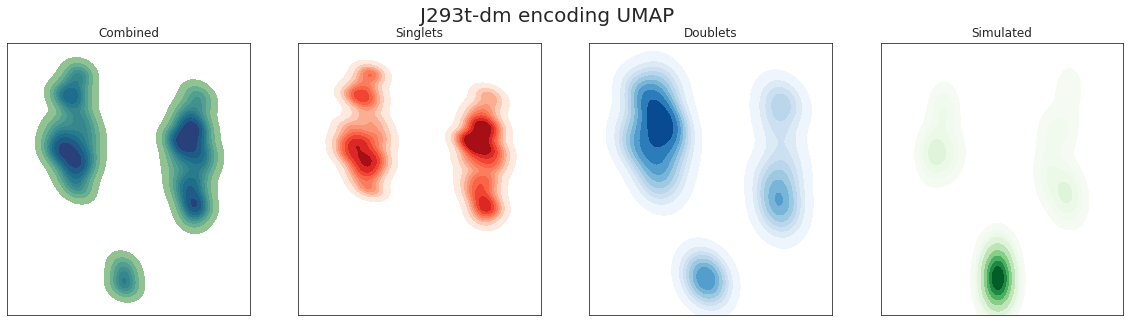

mkidney-ch


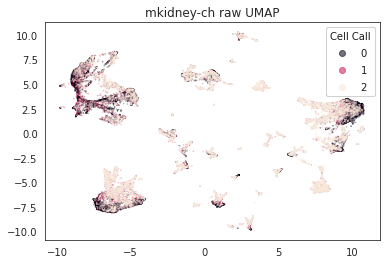

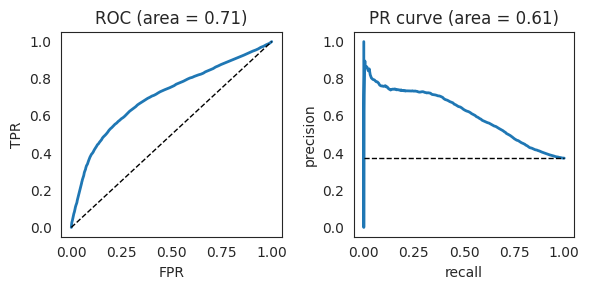

generating new VAE encoding
Epoch 1/1000
678/678 [==============================] - 5s 5ms/step - loss: 93607.9551 - val_loss: 72003.3359
Epoch 2/1000
678/678 [==============================] - 3s 5ms/step - loss: 75934.2918 - val_loss: 69558.5234
Epoch 3/1000
678/678 [==============================] - 3s 4ms/step - loss: 72418.8669 - val_loss: 68114.7109
Epoch 4/1000
678/678 [==============================] - 3s 5ms/step - loss: 70409.7897 - val_loss: 67336.8359
Epoch 5/1000
678/678 [==============================] - 3s 5ms/step - loss: 69181.4630 - val_loss: 66842.9375
Epoch 6/1000
678/678 [==============================] - 3s 5ms/step - loss: 67786.4316 - val_loss: 66906.5625
Epoch 7/1000
678/678 [==============================] - 3s 5ms/step - loss: 67231.8367 - val_loss: 66703.9766
Epoch 8/1000
678/678 [==============================] - 3s 5ms/step - loss: 66532.5249 - val_loss: 66639.2812
Epoch 9/1000
678/678 [==============================] - 3s 5ms/step - loss: 66263.2544 - val

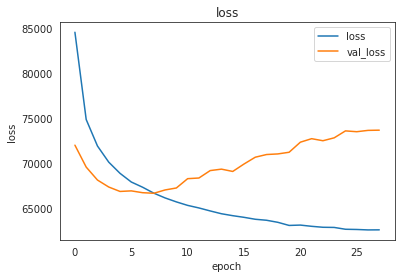

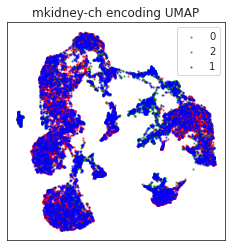

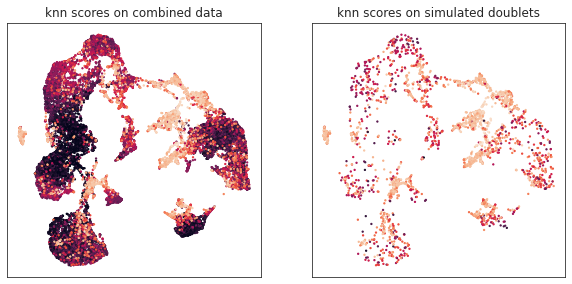

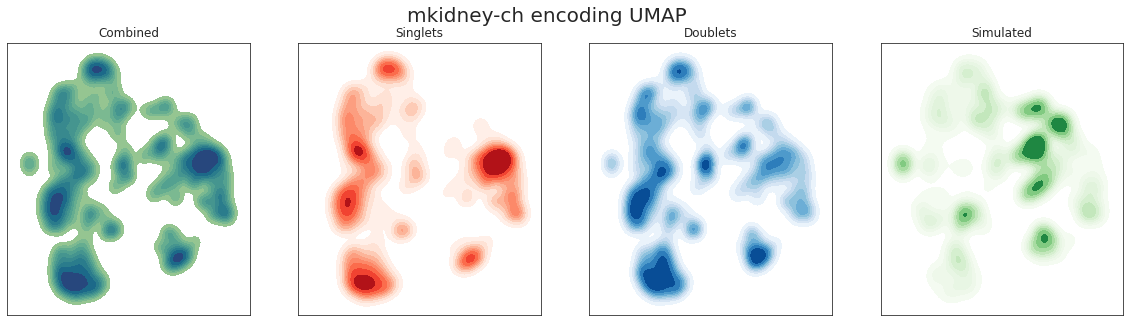

nuc-MULTI


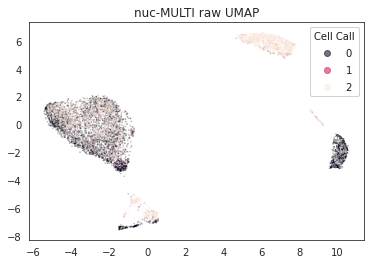

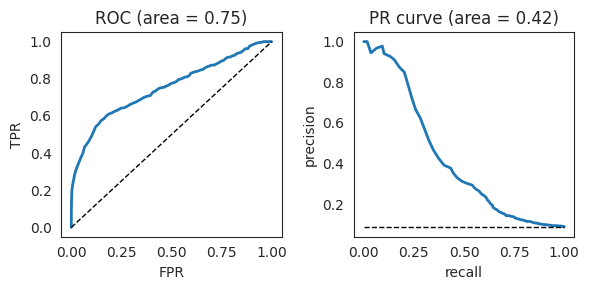

generating new VAE encoding
Epoch 1/1000
174/174 [==============================] - 2s 6ms/step - loss: 121287.4939 - val_loss: 96252.6719
Epoch 2/1000
174/174 [==============================] - 1s 5ms/step - loss: 102629.3748 - val_loss: 90688.2109
Epoch 3/1000
174/174 [==============================] - 1s 5ms/step - loss: 97176.9377 - val_loss: 87811.4297
Epoch 4/1000
174/174 [==============================] - 1s 5ms/step - loss: 92409.0468 - val_loss: 85913.1797
Epoch 5/1000
174/174 [==============================] - 1s 5ms/step - loss: 90279.9271 - val_loss: 84516.5703
Epoch 6/1000
174/174 [==============================] - 1s 5ms/step - loss: 88533.2507 - val_loss: 83704.0703
Epoch 7/1000
174/174 [==============================] - 1s 5ms/step - loss: 86927.7803 - val_loss: 82950.7266
Epoch 8/1000
174/174 [==============================] - 1s 5ms/step - loss: 86311.4728 - val_loss: 82499.3047
Epoch 9/1000
174/174 [==============================] - 1s 5ms/step - loss: 84368.3520 - v

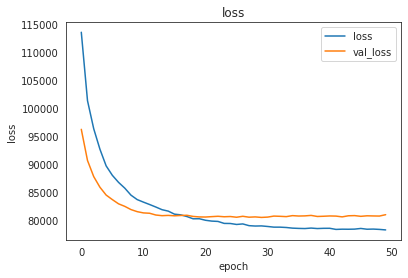

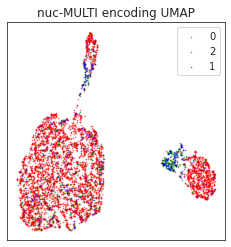

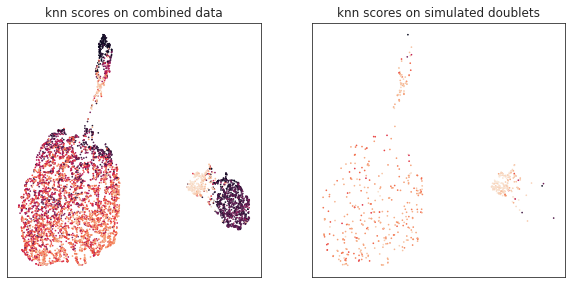

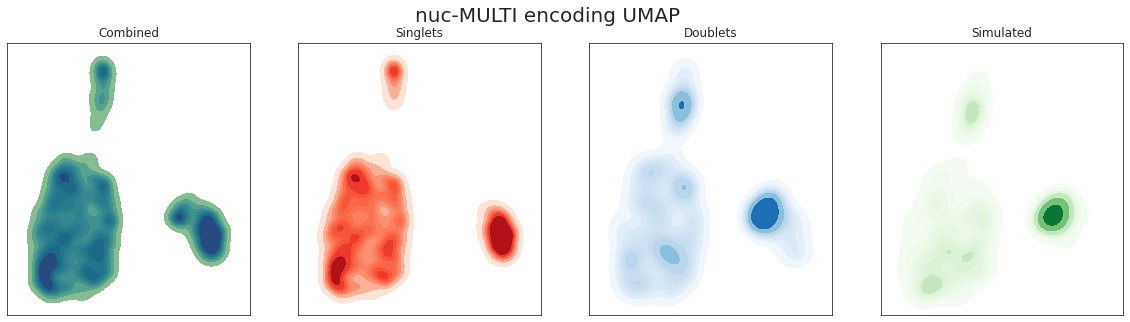

pbmc-1B-dm


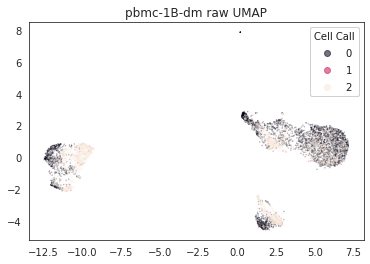

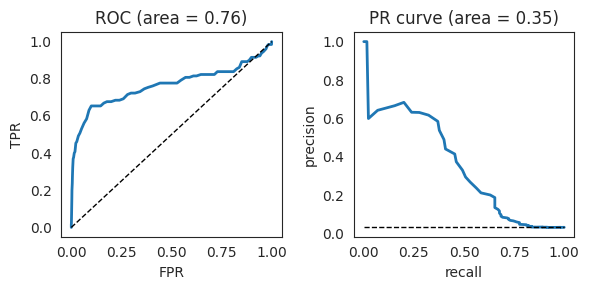

generating new VAE encoding
Epoch 1/1000
116/116 [==============================] - 2s 7ms/step - loss: 129464.4385 - val_loss: 102291.0234
Epoch 2/1000
116/116 [==============================] - 1s 11ms/step - loss: 111417.8707 - val_loss: 99268.7891
Epoch 3/1000
116/116 [==============================] - 1s 5ms/step - loss: 106349.8999 - val_loss: 97119.4922
Epoch 4/1000
116/116 [==============================] - 1s 5ms/step - loss: 102527.3371 - val_loss: 95901.7344
Epoch 5/1000
116/116 [==============================] - 1s 5ms/step - loss: 100267.7053 - val_loss: 94975.1797
Epoch 6/1000
116/116 [==============================] - 1s 5ms/step - loss: 98294.8210 - val_loss: 93972.1875
Epoch 7/1000
116/116 [==============================] - 1s 5ms/step - loss: 96684.3986 - val_loss: 92986.4219
Epoch 8/1000
116/116 [==============================] - 1s 5ms/step - loss: 95241.1442 - val_loss: 92147.7734
Epoch 9/1000
116/116 [==============================] - 1s 5ms/step - loss: 94159.088

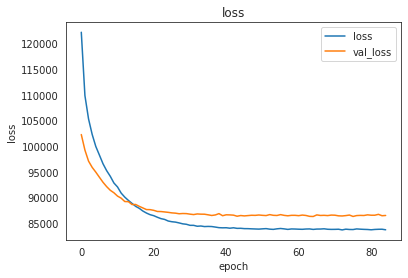

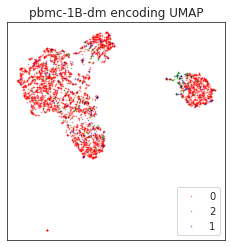

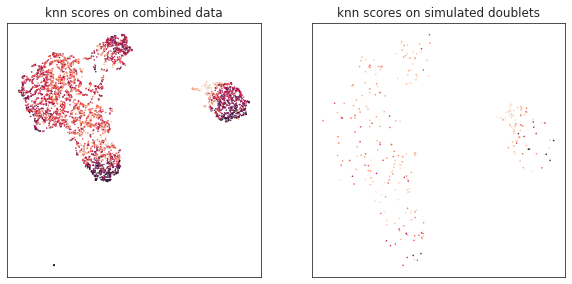

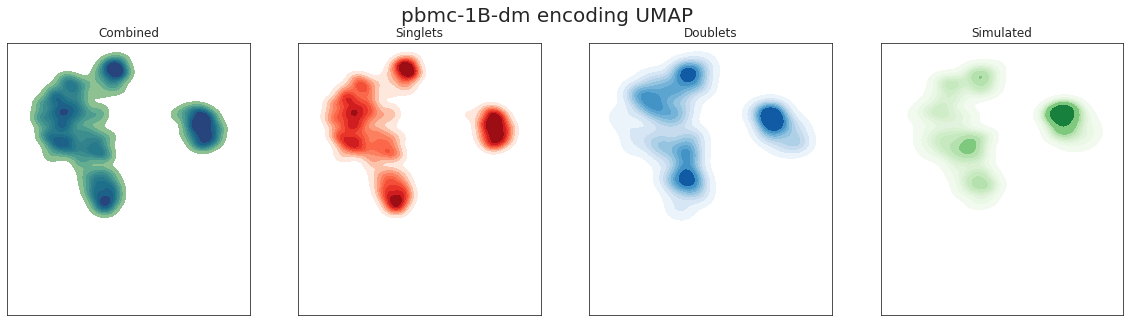

pbmc-1C-dm


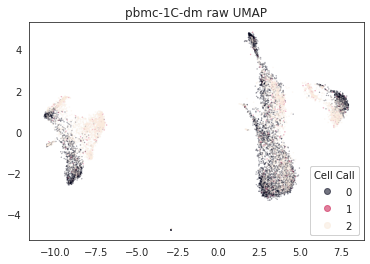

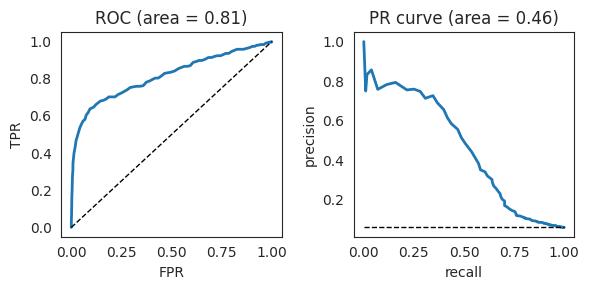

generating new VAE encoding
Epoch 1/1000
161/161 [==============================] - 2s 7ms/step - loss: 124175.9740 - val_loss: 103220.8438
Epoch 2/1000
161/161 [==============================] - 1s 5ms/step - loss: 108042.7150 - val_loss: 99733.5547
Epoch 3/1000
161/161 [==============================] - 1s 5ms/step - loss: 104866.7232 - val_loss: 98187.3438
Epoch 4/1000
161/161 [==============================] - 1s 5ms/step - loss: 101596.3132 - val_loss: 96419.9766
Epoch 5/1000
161/161 [==============================] - 1s 5ms/step - loss: 98509.4040 - val_loss: 95237.9219
Epoch 6/1000
161/161 [==============================] - 1s 5ms/step - loss: 97507.2781 - val_loss: 94127.3125
Epoch 7/1000
161/161 [==============================] - 1s 5ms/step - loss: 95647.3427 - val_loss: 93021.6328
Epoch 8/1000
161/161 [==============================] - 1s 5ms/step - loss: 93834.8832 - val_loss: 92480.5625
Epoch 9/1000
161/161 [==============================] - 1s 5ms/step - loss: 92865.3213 

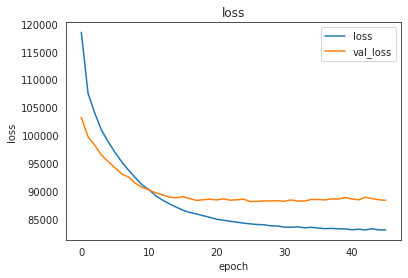

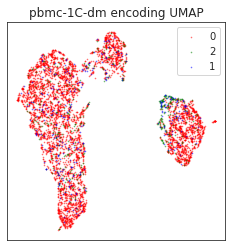

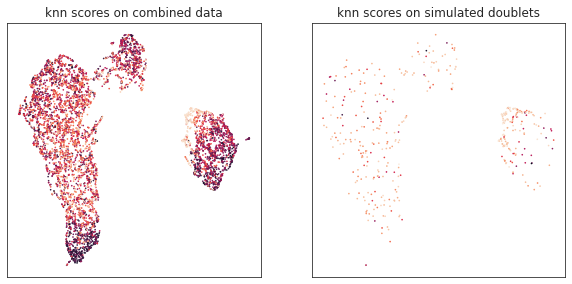

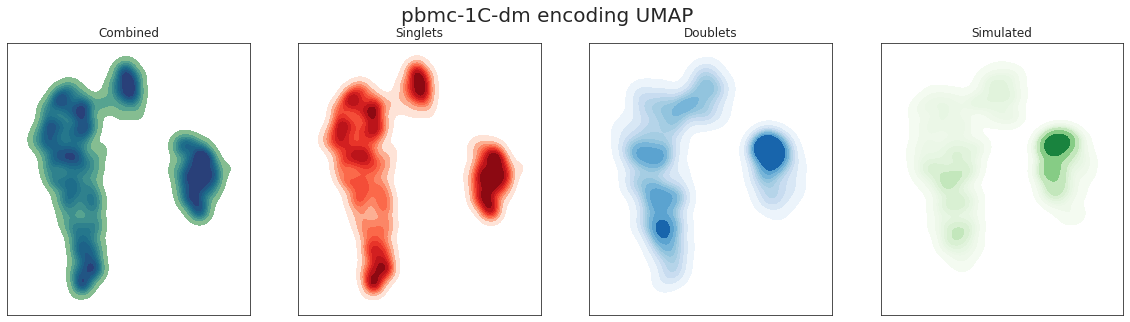

pbmc-2ctrl-dm


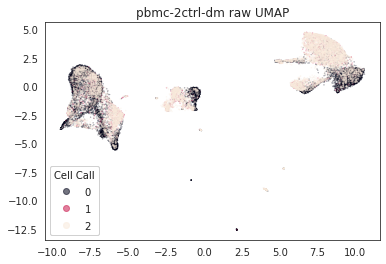

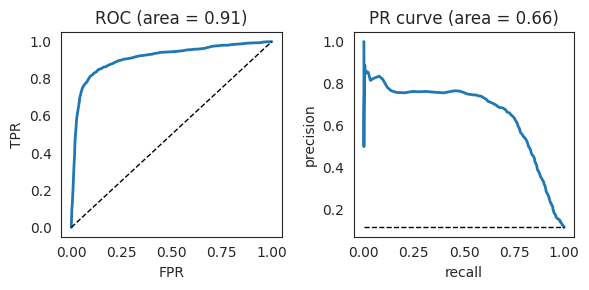

generating new VAE encoding
Epoch 1/1000
432/432 [==============================] - 4s 5ms/step - loss: 114739.8357 - val_loss: 93326.4141
Epoch 2/1000
432/432 [==============================] - 2s 5ms/step - loss: 96709.3113 - val_loss: 88590.9219
Epoch 3/1000
432/432 [==============================] - 2s 5ms/step - loss: 91378.8144 - val_loss: 84803.0938
Epoch 4/1000
432/432 [==============================] - 2s 4ms/step - loss: 86607.5467 - val_loss: 82812.8359
Epoch 5/1000
432/432 [==============================] - 2s 5ms/step - loss: 83740.6705 - val_loss: 81918.6250
Epoch 6/1000
432/432 [==============================] - 3s 6ms/step - loss: 81798.3084 - val_loss: 82020.3828
Epoch 7/1000
432/432 [==============================] - 2s 5ms/step - loss: 80856.5706 - val_loss: 82373.1797
Epoch 8/1000
432/432 [==============================] - 2s 4ms/step - loss: 79980.8638 - val_loss: 83066.8750
Epoch 9/1000
432/432 [==============================] - 2s 5ms/step - loss: 79409.7288 - va

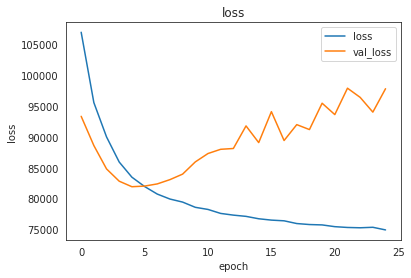

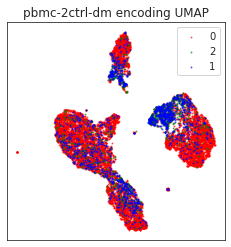

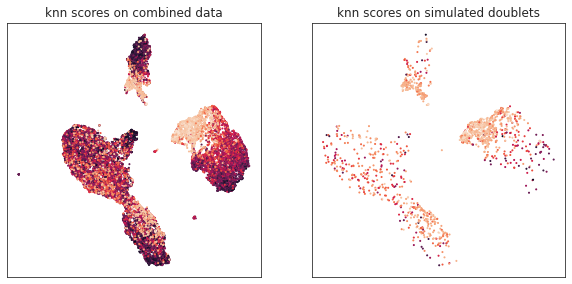

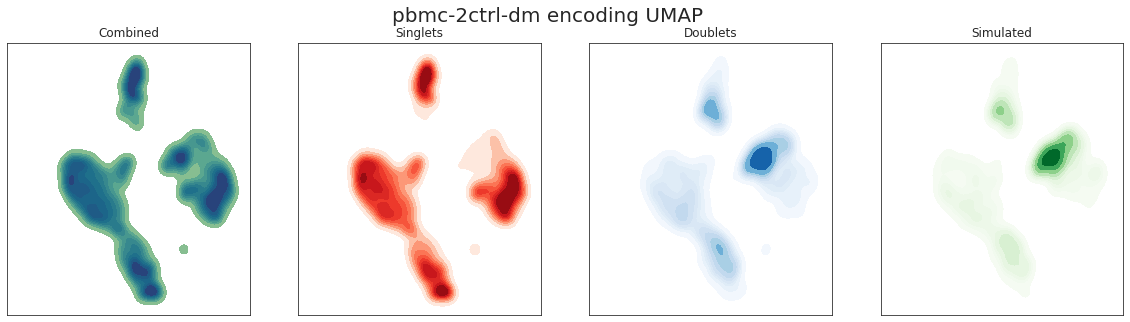

pbmc-2stim-dm


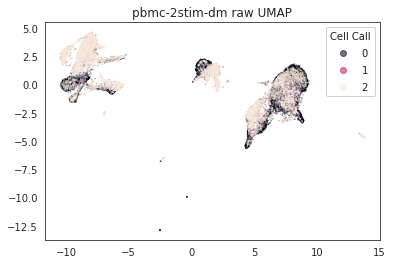

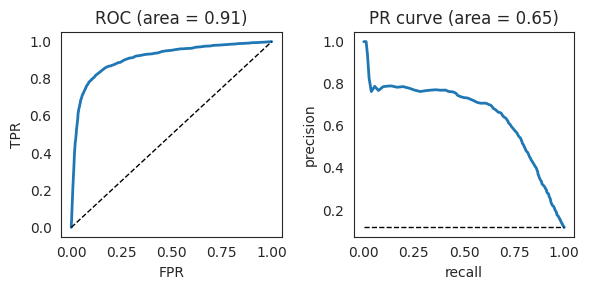

generating new VAE encoding
Epoch 1/1000
432/432 [==============================] - 3s 5ms/step - loss: 110801.2383 - val_loss: 88583.4062
Epoch 2/1000
432/432 [==============================] - 2s 5ms/step - loss: 93895.3532 - val_loss: 83992.1797
Epoch 3/1000
432/432 [==============================] - 2s 5ms/step - loss: 87596.6087 - val_loss: 81035.9453
Epoch 4/1000
432/432 [==============================] - 2s 5ms/step - loss: 83672.5272 - val_loss: 79611.3672
Epoch 5/1000
432/432 [==============================] - 2s 5ms/step - loss: 81463.4526 - val_loss: 78670.0391
Epoch 6/1000
432/432 [==============================] - 2s 5ms/step - loss: 79653.5734 - val_loss: 78994.0781
Epoch 7/1000
432/432 [==============================] - 2s 5ms/step - loss: 78891.9627 - val_loss: 79259.6406
Epoch 8/1000
432/432 [==============================] - 2s 5ms/step - loss: 77965.4577 - val_loss: 79289.8203
Epoch 9/1000
432/432 [==============================] - 2s 5ms/step - loss: 77253.1356 - va

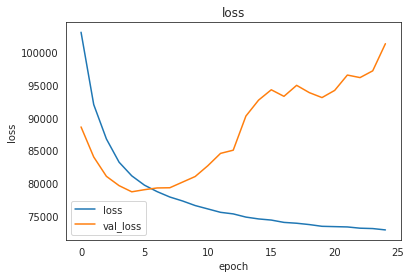

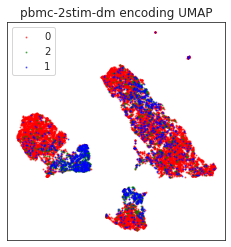

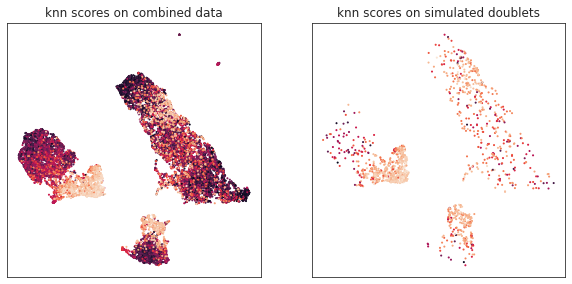

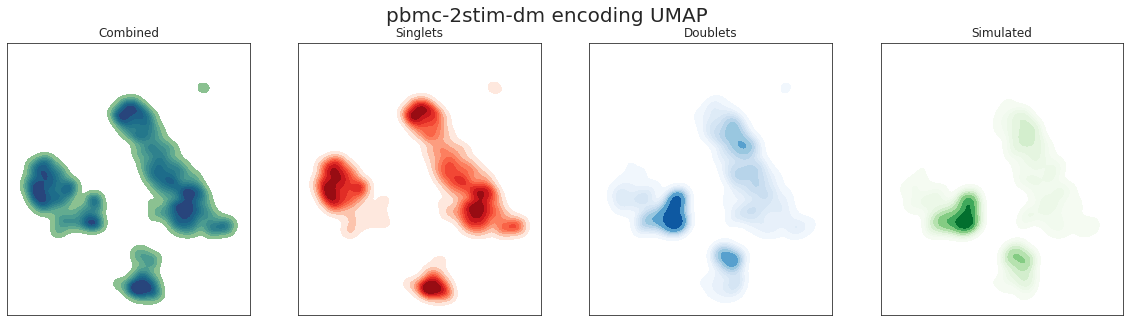

pbmc-ch


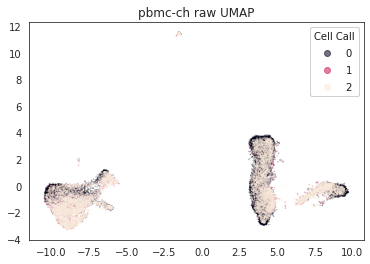

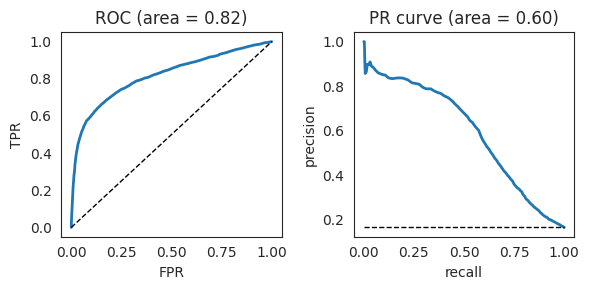

generating new VAE encoding
Epoch 1/1000
481/481 [==============================] - 4s 5ms/step - loss: 121686.4413 - val_loss: 97463.0469
Epoch 2/1000
481/481 [==============================] - 2s 5ms/step - loss: 103329.3151 - val_loss: 92280.0391
Epoch 3/1000
481/481 [==============================] - 2s 5ms/step - loss: 95891.9350 - val_loss: 88098.6797
Epoch 4/1000
481/481 [==============================] - 2s 5ms/step - loss: 90644.2018 - val_loss: 85321.5312
Epoch 5/1000
481/481 [==============================] - 2s 5ms/step - loss: 87299.4467 - val_loss: 83886.8125
Epoch 6/1000
481/481 [==============================] - 2s 5ms/step - loss: 85322.7963 - val_loss: 83077.9609
Epoch 7/1000
481/481 [==============================] - 2s 5ms/step - loss: 83987.3708 - val_loss: 82689.0234
Epoch 8/1000
481/481 [==============================] - 2s 5ms/step - loss: 82944.8005 - val_loss: 83190.4219
Epoch 9/1000
481/481 [==============================] - 2s 5ms/step - loss: 82233.5866 - v

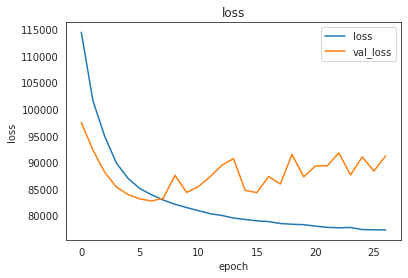

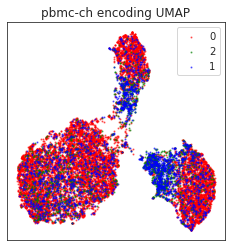

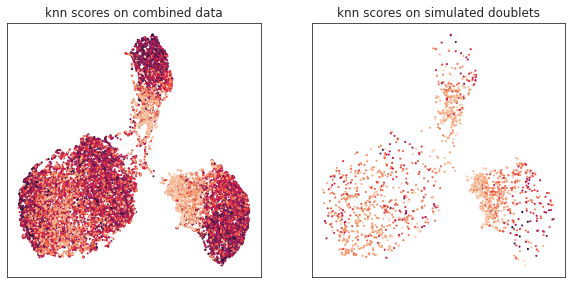

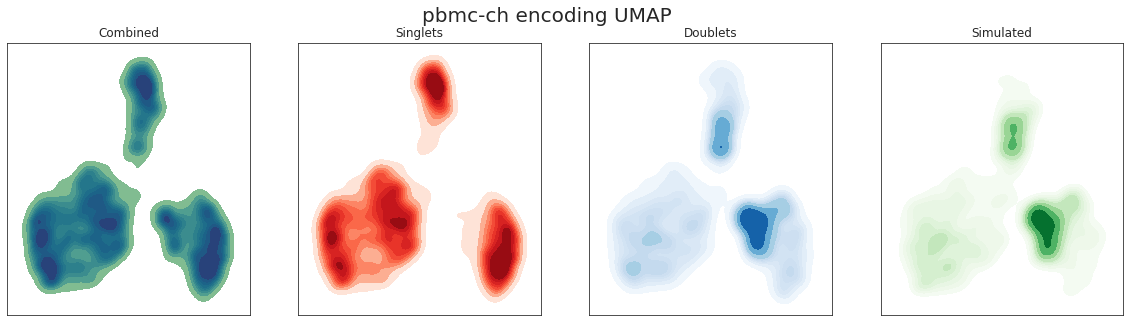

pdx-MULTI


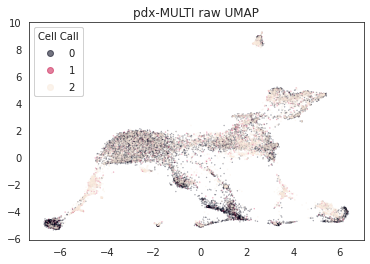

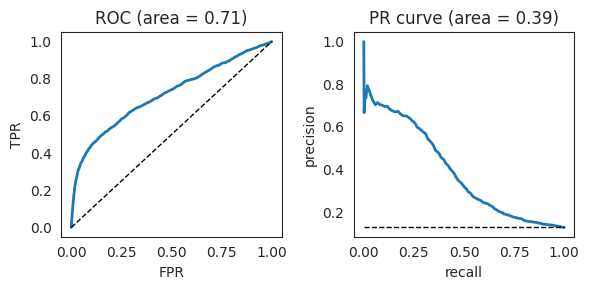

generating new VAE encoding
Epoch 1/1000
335/335 [==============================] - 3s 5ms/step - loss: 127196.6255 - val_loss: 98889.7656
Epoch 2/1000
335/335 [==============================] - 2s 5ms/step - loss: 104133.4267 - val_loss: 93883.9297
Epoch 3/1000
335/335 [==============================] - 2s 5ms/step - loss: 97831.6710 - val_loss: 90795.6719
Epoch 4/1000
335/335 [==============================] - 2s 5ms/step - loss: 93940.4871 - val_loss: 88838.3594
Epoch 5/1000
335/335 [==============================] - 2s 5ms/step - loss: 90808.5492 - val_loss: 87080.9922
Epoch 6/1000
335/335 [==============================] - 2s 5ms/step - loss: 88146.7273 - val_loss: 85717.0469
Epoch 7/1000
335/335 [==============================] - 2s 5ms/step - loss: 86242.4572 - val_loss: 84647.8984
Epoch 8/1000
335/335 [==============================] - 2s 5ms/step - loss: 84349.3647 - val_loss: 83711.7344
Epoch 9/1000
335/335 [==============================] - 2s 5ms/step - loss: 82893.3129 - v

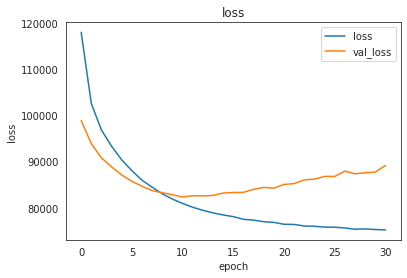

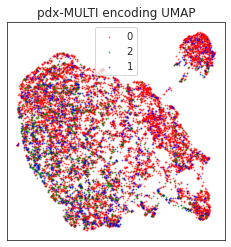

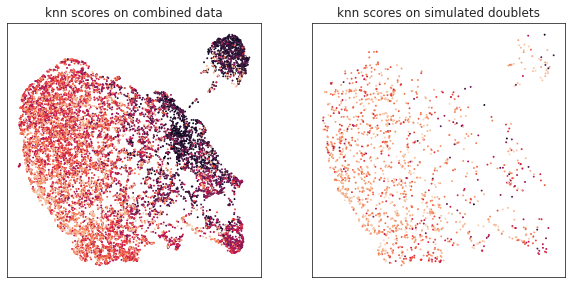

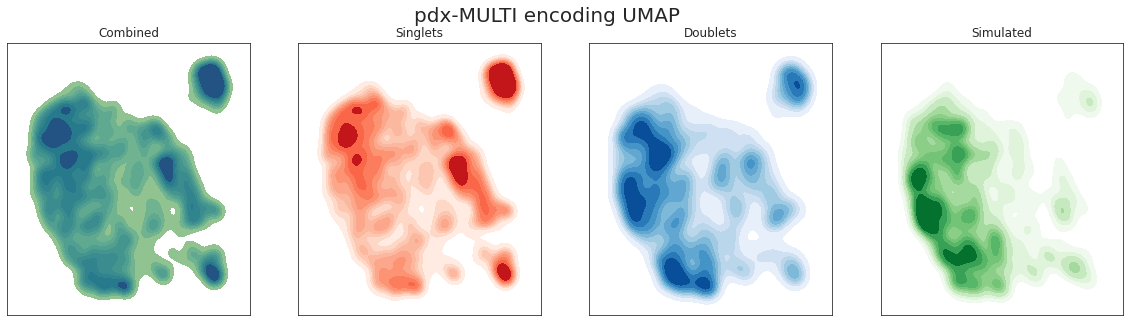

In [65]:
for file in files:

    data_name = file[:-11]

    print(data_name)    
    
    path = '../data/'+ data_dir + '/' + data_name + '_logcounts.npy'
    ano_path  = '../data/'+ data_dir + '/' + data_name + '_colData.csv'
    knn_path = '../data/'+ data_dir + '/' + data_name + '_knn_feature2.npy'
    umap_path = '../data/'+ data_dir + '/' + data_name + '_UMAP.npy'
    hvg_path = '../data/'+ data_dir + '/' + data_name + '_hvgs_realANDsim.npy'    
    
    
    vae_path = '../data/vae_embeddings_scheduled_adamax_5/' + data_name + '_VAE_embedding.npy'
    vae_umap_path = '../data/vae_embeddings_scheduled_adamax_5/' + data_name + '_VAE_UMAP.npy'
    fig_path = '../data/vae_embeddings_scheduled_adamax_5/' + data_name + '_'
    
    #- READ IN COUNTS
    cnts_file = pl.Path(path)
    if cnts_file.exists():
        dat = np.load(cnts_file)#csr sparse matrix format
    else:
        print('does not exist')

    X = scs.csr_matrix(dat).toarray().T

    #- READ IN BARCODE ANNOTATIONS
    ano = pd.read_csv(ano_path)
    true = pd.factorize(ano.doublet_true_labels)[0]
    labels = ano.doublet_true_labels
    if (labels[0]=='doublet'):
        tmp = true + 3
        tmp[tmp==3] = 1
        tmp[tmp==4] = 0
        tmp[tmp==5] = 2
        true = tmp
    
    #- READ IN UMAP
    proj = np.load(umap_path)

    #- HVGs - NEED TO CHECK IF THESE ARE THE RIGHT ORDER THOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
    hvgs = (np.load(hvg_path)).astype(int) - 1
    X = X[:,hvgs] 
    ngens = len(hvgs)

    fig, ax = plt.subplots()
    scatter = ax.scatter(proj[:,0],proj[:,1], c=true, s=0.1, alpha=0.5)
    legend = ax.legend(*scatter.legend_elements(), title= 'Cell Call')
    plt.title(data_name + ' raw UMAP')
    ax.add_artist(legend)
    plt.show()
    plt.close(fig)

    Y = (true>1).astype(int)

    #KNN
    if(data_dir == 'sce_normalized_data'):
        knn_file = pl.Path(knn_path)
        knn_feature = np.load(knn_file)
        res = get_dbl_metrics(true[true<2], knn_feature[true<2])
        plt.show()
        plt.close(fig)

    if(data_dir == 'sce_normalized_data_log_doubs'):
        
        #downsample the simulated doublets
        #ind = np.arange(sum(Y==1))
        #np.random.seed(23958)
        #np.random.shuffle(ind)

        #num = int(sum(Y==1) * (1/2))
        #ind = sum(Y==0) + ind

        #down_ind = np.concatenate([np.arange(sum(Y==0)), ind[:num]])
        #X = X[down_ind,:]
        #Y = Y[down_ind]
        #true = true[down_ind]
        
        pca = PCA(n_components=32)
        pca_proj = pca.fit_transform(X)

        np.random.seed(42)
        knn = NearestNeighbors(n_neighbors=neighbors)
        knn.fit(pca_proj,Y)
        graph = knn.kneighbors_graph(pca_proj)
        knn_feature = np.squeeze(np.array(np.sum(graph[:,Y==1], axis=1) / neighbors)) #sum across rows

        plt.figure(0)
        res = get_dbl_metrics(true[true<2], knn_feature[true<2])
        plt.show()
        plt.close(fig)
    
    
    #SCALE THE FEATURES
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    #downsample the simulated doublets
    #estimate true faction of doublets 
    #mean = np.mean(knn_feature)
    #meanstd = mean + (0.5*np.std(knn_feature))
    quantile = np.quantile(knn_feature[true==2], .25)
    #num = np.sum(knn_feature[true<2]>meanstd)
    num = np.sum(knn_feature[true<2]>quantile)
    
    
    min_num = int(np.round((sum(Y==0) *0.05)))

    num = np.max([min_num, num])
    
    prob = knn_feature[Y==1] / np.sum(knn_feature[Y==1])
    np.random.seed(seeds[0])
    ind = np.random.choice(np.arange(sum(Y==1)), size=num, p=prob, replace=False)
    
    ind = sum(Y==0) + ind

    #enc_ind = np.concatenate([np.arange(sum(Y==0)), ind[:num]])
    enc_ind = np.concatenate([np.arange(sum(Y==0)), ind])
    X = X[enc_ind,:]
    Y = Y[enc_ind]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=12345)
    
    #VAE
    vae_file = pl.Path(vae_path)
    if (vae_file.exists() & (use_old)):
        encoding = np.load(vae_file)
        made_new=False
    else:
        print('generating new VAE encoding')
        made_new=True
        tf.random.set_seed(seeds[1])
        vae = define_vae(enc_sze, ngens)
        
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    mode = 'min',
                                                    min_delta=0, 
                                                    patience=20, 
                                                    verbose=True, 
                                                    restore_best_weights=False)
        
        # This function keeps the initial learning rate for the first ten epochs
        # and decreases it exponentially after that.
        def scheduler(epoch, lr):
            if epoch < 3:
                return lr
            else:
                return lr * tf.math.exp(-0.1)
        
        callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler)

        hist = vae.fit(x=X_train,
                       y=X_train,
                       validation_data=(X_test, X_test),
                       epochs=eps, 
                       use_multiprocessing=True,
                       callbacks=[callback, callback2])
        
        plt.figure(1)
        plt_loss(hist)
        if(save):
            plt.savefig(fig_path + 'loss.png', dpi=300)
        plt.show()
        plt.close(fig)

        encoder = vae.get_layer('encoder')
        tf.random.set_seed(seeds[2])
        encoding = np.array(tf.convert_to_tensor(encoder(X)))

        if save:
            np.save(vae_path, encoding)

    #encoding = np.vstack([knn_feature[enc_ind],encoding.T]).T
    #enc_sze = enc_sze+1

    vae_umap_file = pl.Path(vae_umap_path)
    if (vae_umap_file.exists() & (use_old) & (not made_new)):
        proj_enc = np.load(vae_umap_file)        
    else:
        proj_enc = um.UMAP(n_neighbors=7).fit_transform(encoding)
        if(save):
            np.save(vae_umap_path, proj_enc)
        
    fig, ax = plt.subplots()
    cols = ['r', 'b', 'g']
    size=.00007 * encoding.shape[0]
    for i in [0,2,1]:
        scatter = ax.scatter(proj_enc[true[enc_ind]==i,0],proj_enc[true[enc_ind]==i,1], s=size, c=cols[i], alpha=0.5, label=str(i))

    plt.title(data_name + ' encoding UMAP')
    plt.legend()
    #make square
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    #remove ticks
    plt.tick_params(axis='both', 
                    which='both', 
                    bottom=False, 
                    top=False, 
                    labelbottom=False, 
                    right=False, 
                    left=False, 
                    labelleft=False)
    if save:
        plt.savefig(fig_path + 'UMAP.png', dpi=300)
    plt.show()
    plt.close(fig)
    
    
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].scatter(proj_enc[:,0],proj_enc[:,1], s=size, c=knn_feature[enc_ind])
    #make square
    x0,x1 = ax[0].get_xlim()
    y0,y1 = ax[0].get_ylim()
    ax[0].set_aspect(abs(x1-x0)/abs(y1-y0))
    #remove ticks
    ax[0].set(yticklabels=[])
    ax[0].set(xticklabels=[])
    ax[0].set_title('knn scores on combined data')

    new_ind = enc_ind[true[enc_ind]==2]
    ax[1].scatter(proj_enc[true[enc_ind]==2,0],proj_enc[true[enc_ind]==2,1], s=size, c=knn_feature[new_ind])
    #make square
    x0,x1 = ax[1].get_xlim()
    y0,y1 = ax[1].get_ylim()
    ax[1].set_aspect(abs(x1-x0)/abs(y1-y0))
    #remove ticks
    ax[1].set(yticklabels=[])
    ax[1].set(xticklabels=[])
    ax[1].set_title('knn scores on simulated doublets')

    if save:
        plt.savefig(fig_path + 'UMAP_knnfeature.png', dpi=300)
    plt.show()
    plt.close(fig)



    
    # libraries & dataset
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set_style("white")

    # Basic 2D density plot
    fig, axes = plt.subplots(1, 4, sharex=True, figsize=(20,5))

    plot0 = sns.kdeplot(ax=axes[0], x=proj_enc[:,0], y=proj_enc[:,1], cmap="crest", shade=True, bw_adjust=.5)
    axes[0].set_title('Combined')
    plot0.set(yticklabels=[])
    plot0.set(xticklabels=[])
    x0,x1 = axes[0].get_xlim()
    y0,y1 = axes[0].get_ylim()

    plot1 = sns.kdeplot(ax=axes[1], x=proj_enc[true[enc_ind]==0,0], y=proj_enc[true[enc_ind]==0,1], cmap="Reds", shade=True, bw_adjust=.5)
    axes[1].set_title('Singlets')
    plot1.set(yticklabels=[])
    plot1.set(ylim=(y0, y1))

    plot2 = sns.kdeplot(ax=axes[2], x=proj_enc[true[enc_ind]==1,0], y=proj_enc[true[enc_ind]==1,1], cmap="Blues", shade=True, bw_adjust=.5)
    axes[2].set_title('Doublets')
    plot2.set(yticklabels=[])
    plot2.set(ylim=(y0, y1))

    plot3 = sns.kdeplot(ax=axes[3], x=proj_enc[true[enc_ind]==2,0], y=proj_enc[true[enc_ind]==2,1], cmap="Greens", shade=True, bw_adjust=.5)
    axes[3].set_title('Simulated')
    plot3.set(yticklabels=[])
    plot3.set(ylim=(y0, y1))


    plt.suptitle(data_name + ' encoding UMAP', fontsize=20)
    if(save):
        plt.savefig(fig_path + 'UMAP_density.png', dpi=300)
    plt.show()
    plt.close(fig)
    
    x = np.arange(len(hist.history['lr']))
    plt.plot(x, np.array(hist.history['lr']), label = 'lr')
    plt.close()



In [138]:
enc_ind

array([    0,     1,     2, ..., 19739, 20977, 22121])

In [148]:
knn_feature
prob

array([8.49511573e-05, 7.73055532e-05, 7.81550647e-05, ...,
       8.32521342e-05, 7.47570185e-05, 8.15531110e-05])

In [147]:
Y = (true>1).astype(int)
np.random.seed(seeds[0])
ind = np.random.choice(np.arange(sum(Y==1)), size=num, p=prob, replace=False)
ind

array([ 4789, 12183,  9378,  7668,  1995,   741, 11093,  7700,  9068,
         265, 12434, 10662,  2719,  2326,  2346,  3888,  6715,  5530,
        3723,  7835,  1785,  3734,  4686,  5840, 10057,  2556,  6581,
        7587,   595,  7782,  2182,   833, 12160, 12376, 10352,  3893,
        1252,  8762,  5636,  1564,  6339,   443, 11652,  3309,  8480,
        3984,  6656,  6996,  2365, 12430,  9929, 12041, 11463,  7658,
       11813,  1133,  2508,   580,  4160,  4970,  3469, 10613,  4564,
        3592,  6945,  1802, 10273,   955, 12654,  9891,  2543,    73,
       10442,  9052,  9340,  9878,   948,  4586,  1486, 11055,  7978,
        4231,   813,  3974,  4158,  9347,  8158, 11363,  6045,  1534,
        9134,  9745,  7182,  9874,  6321,  6689,  5475,   328,  1382,
         406,  8144,  4018,  6509, 11629,  3189,  5252,  9678,  2926,
         985,  3704,  2063, 11913, 10348,  8106, 11160, 10291,  2387,
       11434,  6904, 10339, 11480,  4064,  1411,  2916,  5469, 10475,
       11025,    90,